![Credit card image](https://imgs.search.brave.com/QcVSsv3myirhZzB4beWXs-4_Na2D4v_pAsDn-LoUhNs/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly9tZWRp/YS5pc3RvY2twaG90/by5jb20vaWQvNDg2/OTM3MzIyL3Bob3Rv/L2NyZWRpdC1jYXJk/cy5qcGc_cz02MTJ4/NjEyJnc9MCZrPTIw/JmM9bTRCR1hjMTY1/THlfUHBmYkVIWW5l/Wk1DNXdZUjFSTWR6/a3IxR3k4U1VUVT0)

# Credit Card Default Prediction Analysis

**Objective**: This project focuses on predicting credit card defaults using tree-based gradient boosting models. The primary goal is to evaluate and compare the performance of five ensemble methods: Random Forest, AdaBoost, XGBoost, LightGBM, and CatBoost. By leveraging these models, the project aims to identify key predictors of default and assess their effectiveness in classifying high-risk clients.

## Table of Contents
1. [About the Data](#about-data)
2. [Libraries and Setup](#libraries-and-setup)
3. [Data Loading](#data-loading)
4. [Feature Engineering](#feature-engineering)
5. [Exploratory Data Analysis](#exploratory-data-analysis)
6. [Model Development](#model-development)
7. [Model Evaluation](#model-evaluation)
8. [Feature Importance](#feature-importance)
9. [Conclusion](#conclusion)

## 1. About the Data <a name='about-data'></a>

**Dataset Information**: 
This dataset contains information on default payments, demographic factors, credit data, payment history, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

### Features Description 
The dataset consists of 25 variables:

#### Demographic Information
- **ID**: Unique identifier for each client
- **LIMIT_BAL**: Amount of credit limit in NT dollars (includes individual and family/supplementary credit)
- **SEX**: Gender (1=male, 2=female)
- **EDUCATION**: Education level
  - 1 = graduate school
  - 2 = university
  - 3 = high school
  - 4 = others
  - 5, 6 = unknown
- **MARRIAGE**: Marital status (1=married, 2=single, 3=others)
- **AGE**: Age in years

#### Payment History
- **PAY_0 to PAY_6**: Repayment status from April to September 2005
  - -1 = pay duly
  - 0 = use of revolving credit
  - 1 = payment delay for one month
  - 2 = payment delay for two months
  - ...
  - 8 = payment delay for eight months
  - 9 = payment delay for nine months and above

#### Bill Amounts
- **BILL_AMT1 to BILL_AMT6**: Amount of bill statement from April to September 2005 (NT dollar)

#### Payment Amounts
- **PAY_AMT1 to PAY_AMT6**: Amount of payment made from April to September 2005 (NT dollar)

#### Target Variable
- **default.payment.next.month**: Default payment (1=yes, 0=no)

### Data Collection Period
- Start: April 2005
- End: September 2005

### Data Source
The dataset was collected from credit card clients in Taiwan, providing a comprehensive view of credit card usage patterns and default risk factors. [Dataset Source: Kaggle](https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/data)

## 2. Libraries and Setup <a name="libraries-and-setup"></a>

In [137]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

# Boosting Libraries
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Additional utilities
from scipy.stats import randint, uniform
import time
import warnings

warnings.filterwarnings("ignore")

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 3. Data Loading<a name="data-loading"></a>

**Note:** Update the file path to match your local dataset location.

In [138]:
# Load the data
df = pd.read_csv(
    "../Data/UCI_Credit_Card.csv"
)

# Clean up column names
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(" ", "_")
df.columns = df.columns.str.replace(".", "_")

# Display basic information
print("\nDataset Overview:")
print(f"Shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print("\nBasic statistics:")
print(df.describe().round(2))
print("\nMissing values:")
print(df.isnull().sum().any())
print("\nData types:")
print(df.dtypes)


Dataset Overview:
Shape: (30000, 25)

First 5 rows:
   id  limit_bal  sex  education  marriage  age  pay_0  pay_2  pay_3  pay_4  \
0   1    20000.0    2          2         1   24      2      2     -1     -1   
1   2   120000.0    2          2         2   26     -1      2      0      0   
2   3    90000.0    2          2         2   34      0      0      0      0   
3   4    50000.0    2          2         1   37      0      0      0      0   
4   5    50000.0    1          2         1   57     -1      0     -1      0   

   ...  bill_amt4  bill_amt5  bill_amt6  pay_amt1  pay_amt2  pay_amt3  \
0  ...        0.0        0.0        0.0       0.0     689.0       0.0   
1  ...     3272.0     3455.0     3261.0       0.0    1000.0    1000.0   
2  ...    14331.0    14948.0    15549.0    1518.0    1500.0    1000.0   
3  ...    28314.0    28959.0    29547.0    2000.0    2019.0    1200.0   
4  ...    20940.0    19146.0    19131.0    2000.0   36681.0   10000.0   

   pay_amt4  pay_amt5  pay_amt6  

## 4. Feature Engineering<a name="feature-engineering"></a>

**Key Transformations:**
- Categorical variable mapping
- Derived feature creation
- Age and credit utilization grouping

In [139]:
# Process categorical variables 
education_map = {
    0: 0,  # Unknown
    1: 1,  # Graduate School
    2: 2,  # University
    3: 3,  # High School
    4: 4,  # Others
    5: 0,  # Unknown
    6: 0,  # Unknown
}
df["education_cat"] = df["education"].map(education_map).astype("category")

df["marriage_cat"] = df["marriage"].astype("category")# 0: Unknown, 1: Married, 2: Single, 3: Other

df["sex_cat"] = df["sex"].astype("category")  # 1: Male, 2: Female

# Drop original categorical variables
df = df.drop(columns=["education", "marriage", "sex"])

# Convert PAY_* status columns to category (keeping numeric values)
for n in np.arange(0, 7):
    if n != 1:
        df[f"pay_{n}"] = df[f"pay_{n}"].astype("category")

# Derived Features

# Payment delay trend (linear slope)
pay_cols = [f"pay_{n}" for n in np.arange(0, 7) if n != 1]
df["payment_delay_trend"] = df[pay_cols].apply(
    lambda x: np.polyfit(range(len(x)), x.astype(float), 1)[0], axis=1
)

# Maximum payment delay
df["max_payment_delay"] = df[pay_cols].astype(float).max(axis=1)

# Credit utilization ratios
for n in np.arange(1, 7):
    df[f"utilization_ratio_{n}"] = df[f"bill_amt{n}"] / df["limit_bal"].replace(0, np.nan)

# Age grouping (kept as categorical)
df["age_group"] = pd.cut(
    df["age"],
    bins=[0, 25, 35, 45, 55, 100],
    labels=["18-25", "26-35", "36-45", "46-55", "55+"],
).astype("category")

# Check for missing values
print("\nCheck for missing values:")
print(df.isnull().sum().any())

# Check final data shape
print("\nData shape:")
print(df.shape)


Check for missing values:
False

Data shape:
(30000, 34)


## 5. Exploratory Data Analysis<a name="exploratory-data-analysis"></a>

**Visualization Goals:**
- Understand data distribution
- Identify correlations
- Analyze default patterns across demographics

In [140]:
# Define feature types
numerical_features = [
    col for col in df.columns if df[col].dtype in ["int64", "float64"]
]
categorical_features = [col for col in df.columns if df[col].dtype == "category"]

print("\nCheck all columns are captured:")
df.shape[1] == len(numerical_features) + len(categorical_features)



Check all columns are captured:


True

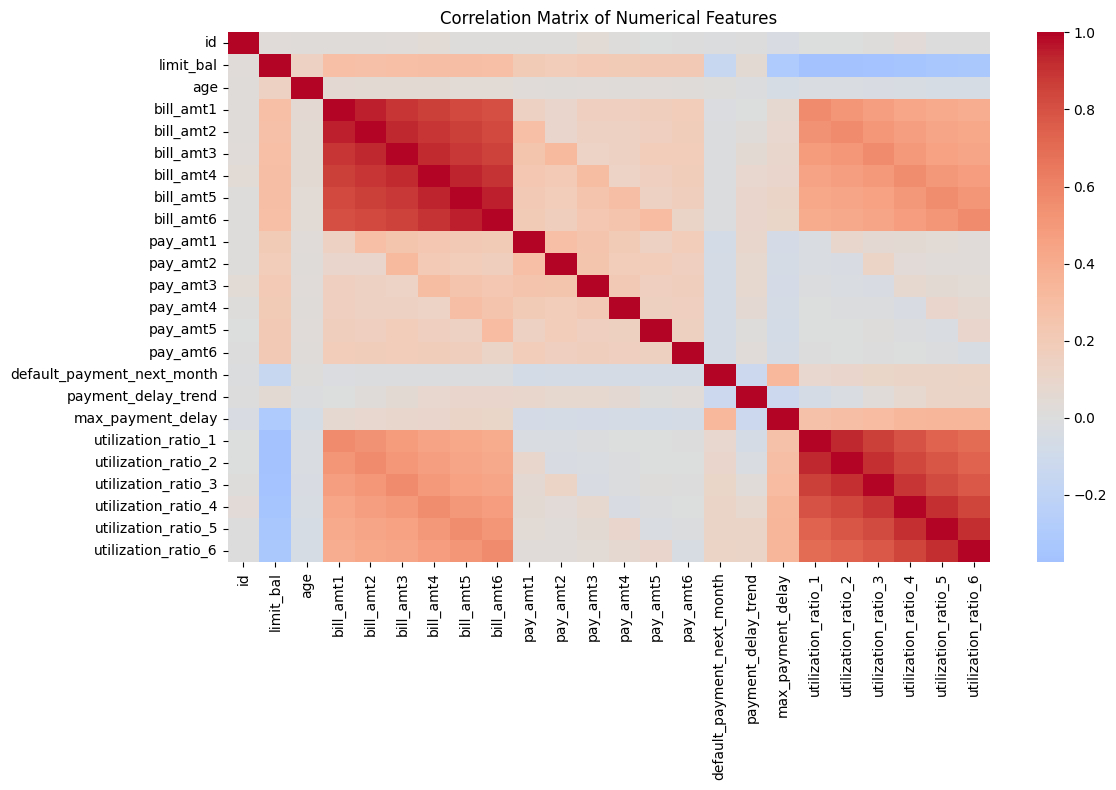


Top correlations of numerical features with default payment next month:
0.33 for max_payment_delay
0.15 for limit_bal
0.13 for payment_delay_trend
0.12 for utilization_ratio_6
0.12 for utilization_ratio_5
0.12 for utilization_ratio_4
0.1 for utilization_ratio_3
0.1 for utilization_ratio_2
0.09 for utilization_ratio_1
0.07 for pay_amt1


In [141]:
# Correlation analysis with numerical features
plt.figure(figsize=(12, 8))
corr_matrix = df[numerical_features].corr()
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()

# Find top correlations with target
top_corr_vars = (
    corr_matrix["default_payment_next_month"]
    .abs()
    .sort_values(ascending=False)
    .index[1:11]  
)
top_corr_vals = (
    corr_matrix["default_payment_next_month"]
    .abs()
    .sort_values(ascending=False)
    .iloc[1:11]  
    .round(2)
)
print("\nTop correlations of numerical features with default payment next month:")
for var, val in zip(top_corr_vars, top_corr_vals):
    print(f"{val} for {var}")


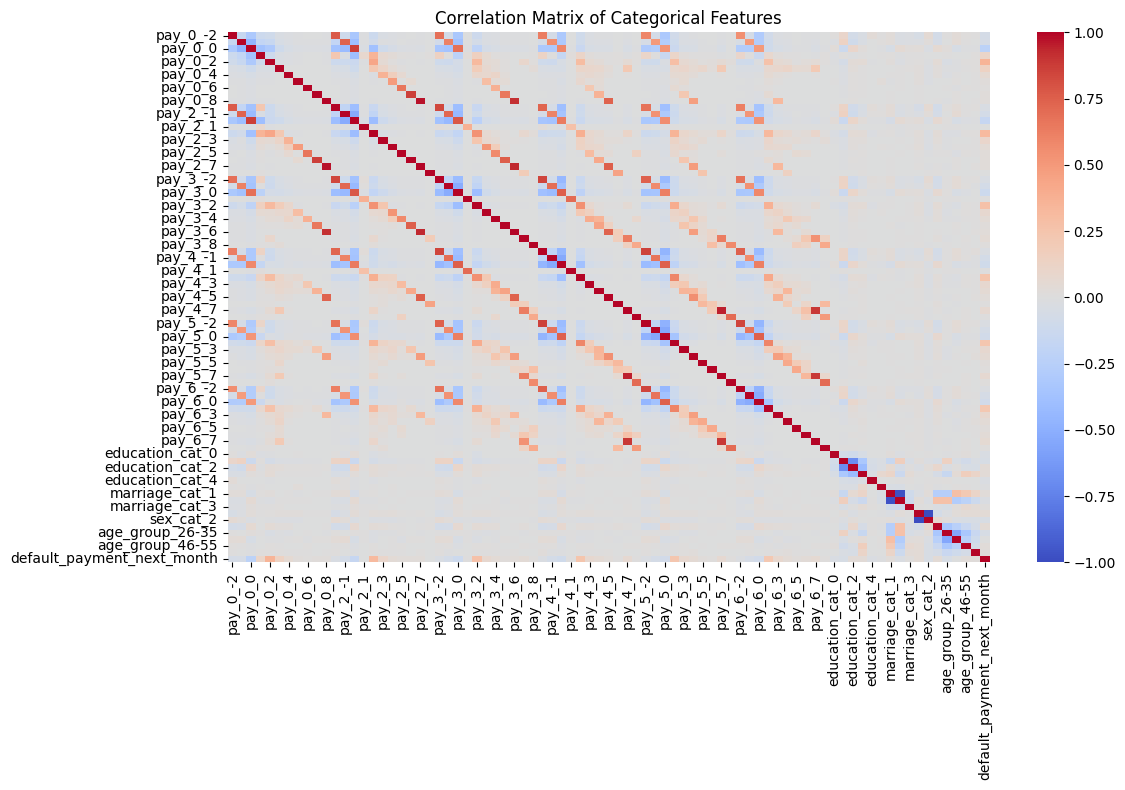


Top correlations of catgorical features with default payment next month:
0.35 for pay_0_2
0.31 for pay_2_2
0.27 for pay_3_2
0.25 for pay_4_2
0.24 for pay_5_2
0.22 for pay_0_0
0.22 for pay_6_2
0.16 for pay_2_0
0.13 for pay_0_3
0.12 for pay_3_0


In [142]:
# Correlation analysis with categorical features
plt.figure(figsize=(12, 8))

# Convert categorical columns to numeric for correlation analysis
cat_df = pd.get_dummies(df[categorical_features])
cat_df['default_payment_next_month'] = df['default_payment_next_month']

# Calculate correlation matrix
corr_matrix = cat_df.corr()
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Categorical Features")
plt.tight_layout()
plt.show()

# Find top correlations with target
top_corr_vars = (
    corr_matrix["default_payment_next_month"]
    .abs()
    .sort_values(ascending=False)
    .index[1:11]  
)
top_corr_vals = (
    corr_matrix["default_payment_next_month"]
    .abs()
    .sort_values(ascending=False)
    .iloc[1:11]  
    .round(2)
)
print("\nTop correlations of catgorical features with default payment next month:")
for var, val in zip(top_corr_vars, top_corr_vals):
    print(f"{val} for {var}")

### Key Correlations Analysis

- **Bill Amounts** and **Utilization Ratios** show strong positive correlations, particularly between adjacent months. This reflects consistent credit usage and billing behavior over time, with correlation strength decreasing as the time gap between months increases.

- A clear positive relationship exists between **Bill Amounts** and **Utilization Ratios**, confirming that higher billing amounts typically lead to higher credit utilization.

- The target variable, **Default Payment Next Month**, has its strongest correlation (**0.33**) with **Max Payment Delay**, followed by moderate correlations with:
  - **Payment Delay Trend** (0.13)
  - **Utilization Ratios** (0.12–0.09 across months)
  - **Limit Balance** (0.15, negative correlation indicating lower limits are associated with higher default risk)
  - **Pay Amount 1** (0.07)

- Among **categorical variables**, the most predictive are payment statuses, especially when delayed by two months:
  - `pay_0_2` (0.35), `pay_2_2` (0.31), and others such as `pay_3_2`, `pay_4_2`, `pay_5_2` and `pay_6_2` also show moderate correlation (0.22–0.27).
  - Earlier "no delay" statuses like `pay_0_0` and `pay_2_0` show negative or inverse correlations, reinforcing the predictive value of recent payment behavior.

- **Demographic features**, including **Age**, **Sex**, **Education**, and **Marriage**, display weak correlations with default behavior and with other features, suggesting limited predictive power on their own but potential usefulness in interaction with other variables.


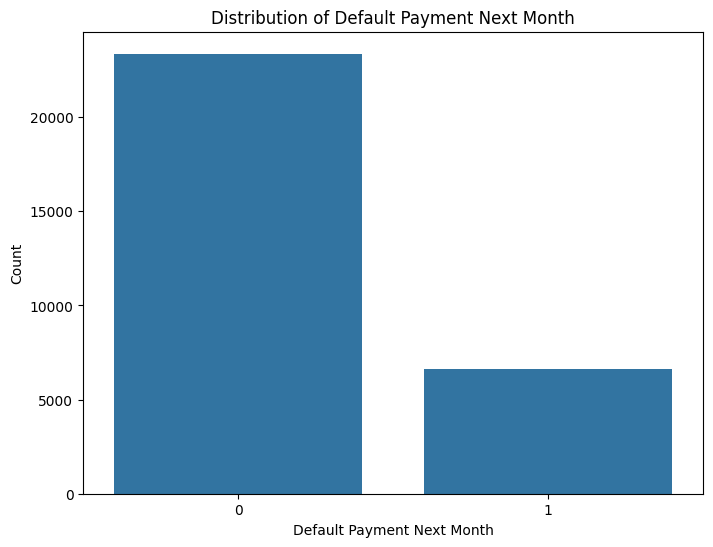


Overall default rate: 22.12%


In [143]:
# Target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(x="default_payment_next_month", data=df)
plt.title("Distribution of Default Payment Next Month")
plt.xlabel("Default Payment Next Month")
plt.ylabel("Count")
plt.show()

default_rate = df["default_payment_next_month"].value_counts(normalize=True)[1].round(4)
print(f"\nOverall default rate: {default_rate*100}%")

### Class Distribution & Imbalance Handling

The target variable `Default Payment Next Month` is imbalanced, with a default rate of **22.12%**. Most observations fall under class `0` (no default), while class `1` (default) is underrepresented.

To address this during model training, I account for the imbalance by:

- Setting `class_weight="balanced"` in models like **Random Forest** and **AdaBoost**.
- Using `scale_pos_weight` (tuned with a uniform distribution from 2 to 6) in **XGBoost**, **LightGBM**, and **CatBoost**.  
  (The actual value based on class distribution is approximately **3.52**, calculated as the ratio of negative to positive class samples.)

This helps the models better account for the underrepresented class and improves their ability to detect potential defaulters.


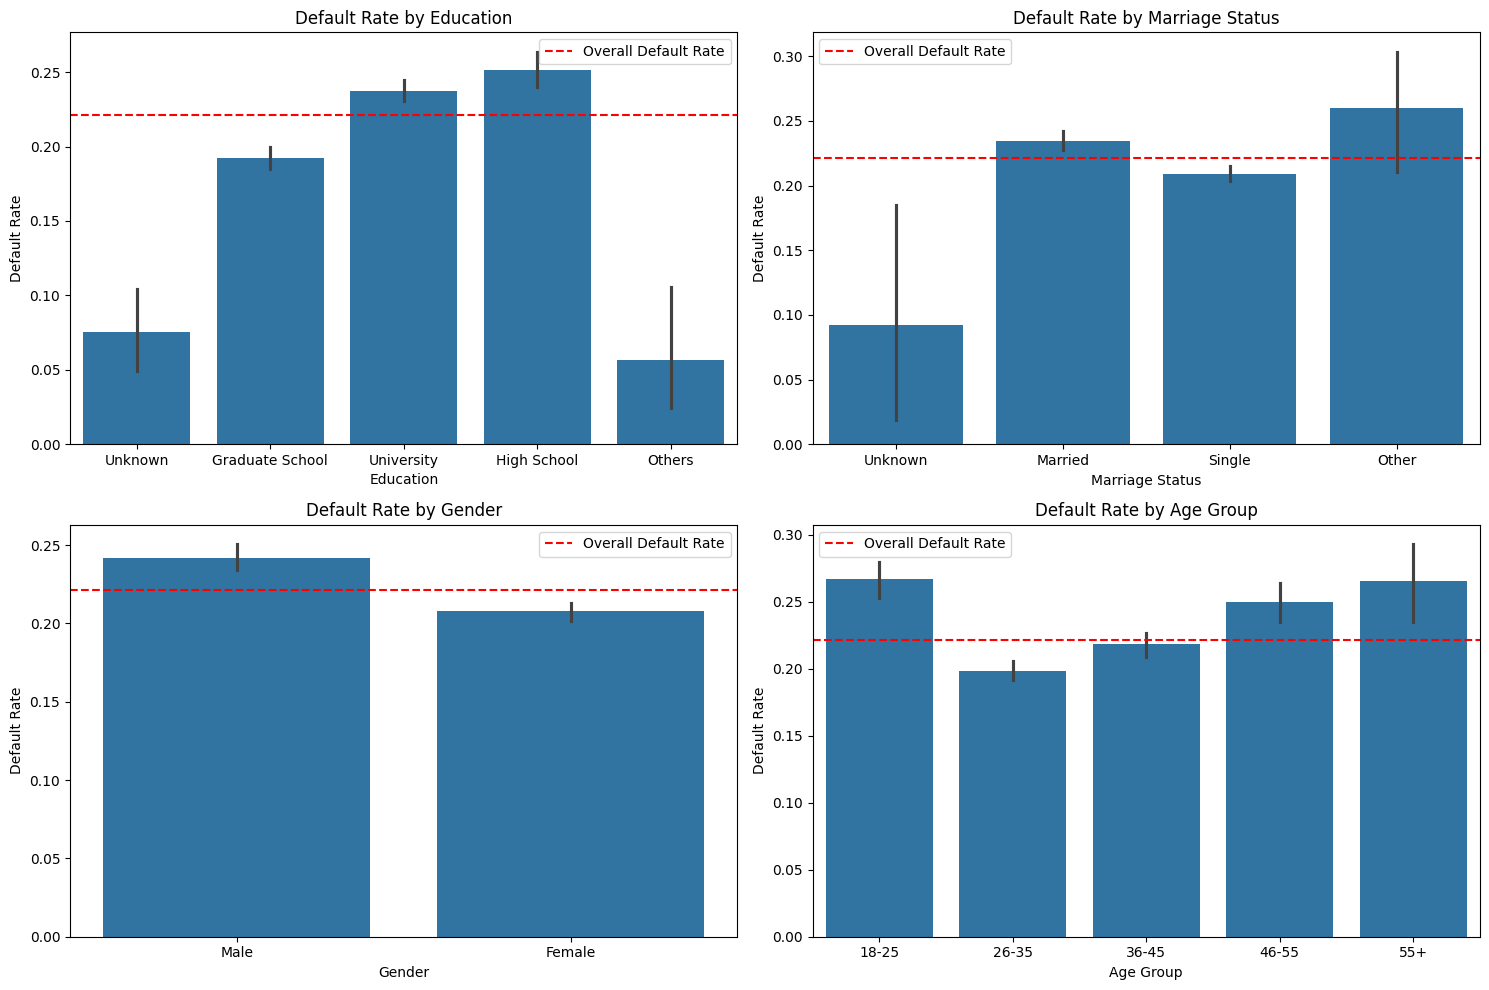

In [144]:
# Demographic analysis with descriptive category labels
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Mapping for better x-axis labels
education_labels = ["Unknown", "Graduate School", "University", "High School", "Others"]
marriage_labels = ["Unknown", "Married", "Single", "Other"]
sex_labels = ["Male", "Female"]
age_labels = ["18-25", "26-35", "36-45", "46-55", "55+"]

# Education analysis
sns.barplot(x="education_cat", y="default_payment_next_month", data=df, ax=axes[0, 0])
axes[0, 0].set_title("Default Rate by Education")
axes[0, 0].set_xlabel("Education")
axes[0, 0].set_ylabel("Default Rate")
axes[0, 0].set_xticklabels(education_labels)
axes[0, 0].axhline(
    y=df["default_payment_next_month"].mean(),
    color="r",
    linestyle="--",
    label="Overall Default Rate",
)
axes[0, 0].legend()

# Marriage analysis
sns.barplot(x="marriage_cat", y="default_payment_next_month", data=df, ax=axes[0, 1])
axes[0, 1].set_title("Default Rate by Marriage Status")
axes[0, 1].set_xlabel("Marriage Status")
axes[0, 1].set_ylabel("Default Rate")
axes[0, 1].set_xticklabels(marriage_labels)
axes[0, 1].axhline(
    y=df["default_payment_next_month"].mean(),
    color="r",
    linestyle="--",
    label="Overall Default Rate",
)
axes[0, 1].legend()

# Gender analysis
sns.barplot(x="sex_cat", y="default_payment_next_month", data=df, ax=axes[1, 0])
axes[1, 0].set_title("Default Rate by Gender")
axes[1, 0].set_xlabel("Gender")
axes[1, 0].set_ylabel("Default Rate")
axes[1, 0].set_xticklabels(sex_labels)
axes[1, 0].axhline(
    y=df["default_payment_next_month"].mean(),
    color="r",
    linestyle="--",
    label="Overall Default Rate",
)
axes[1, 0].legend()

# Age analysis
sns.barplot(x="age_group", y="default_payment_next_month", data=df, ax=axes[1, 1])
axes[1, 1].set_title("Default Rate by Age Group")
axes[1, 1].set_xlabel("Age Group")
axes[1, 1].set_ylabel("Default Rate")
axes[1, 1].set_xticklabels(age_labels)
axes[1, 1].axhline(
    y=df["default_payment_next_month"].mean(),
    color="r",
    linestyle="--",
    label="Overall Default Rate",
)
axes[1, 1].legend()

plt.tight_layout()
plt.show()


### Default Rate by Demographics

- **Education**: Default rates vary across education levels. Individuals with a **high school** or **university** education show above-average default rates, while those with **graduate school** education tend to default less. The **"Others"** and **"Unknown"** categories have the lowest rates, though these may be underrepresented or noisy.

- **Marriage Status**: **Single** individuals have slightly lower default rates than **married**, while the **"Other"** group shows a noticeably higher rate, albeit with larger uncertainty. The **"Unknown"** group has the lowest rate but may lack reliable sample size.

- **Gender**: **Male** borrowers have a higher default rate than **females**, both in absolute terms and relative to the overall average (22.12%).

- **Age Group**: Default rates are highest among the youngest (18–25) and oldest (55+) age groups. The lowest default rate is observed in the **26–35** group, suggesting a more stable repayment behavior in early adulthood.

These insights suggest that demographic features, while not highly correlated individually, still carry signal that could be useful in segmentation or model inputs.


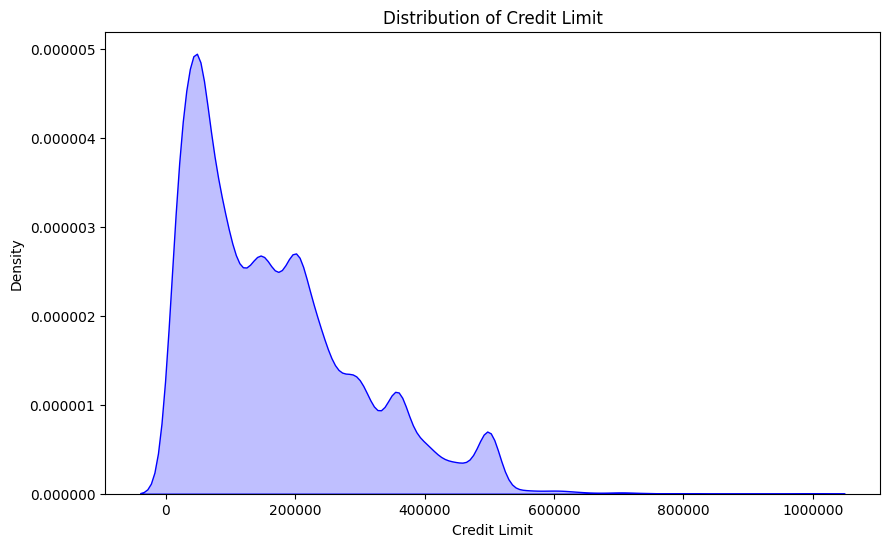

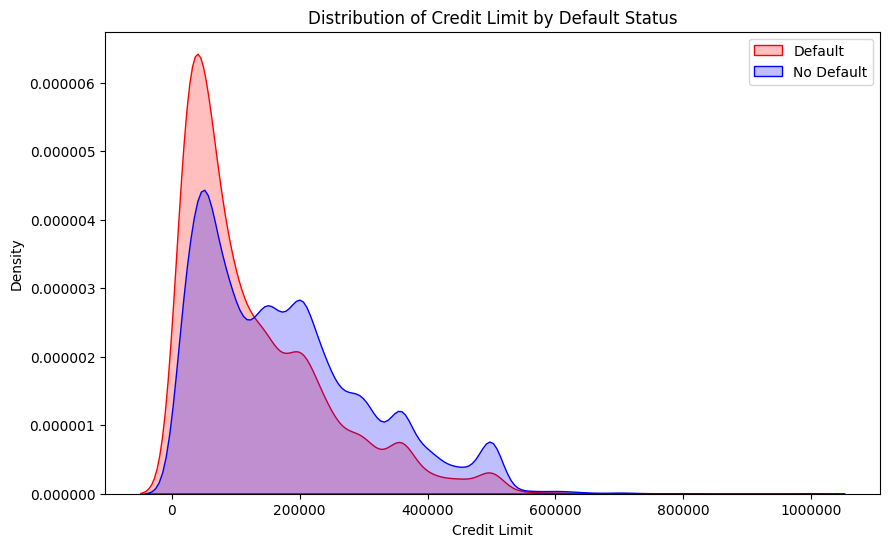

In [145]:
# Credit limit analysis
plt.figure(figsize=(10, 6))
sns.kdeplot(df["limit_bal"], color="blue", shade=True)
plt.title("Distribution of Credit Limit")
plt.xlabel("Credit Limit")
plt.ylabel("Density")
plt.ticklabel_format(style="plain", axis="both", useOffset=False)
plt.show()

# Credit limit by default status
plt.figure(figsize=(10, 6))
plt.title("Distribution of Credit Limit by Default Status")
plt.xlabel("Credit Limit")
plt.ylabel("Density")
sns.kdeplot(
    df[df["default_payment_next_month"] == 1]["limit_bal"],
    color="red",
    shade=True,
    label="Default",
)
sns.kdeplot(
    df[df["default_payment_next_month"] == 0]["limit_bal"],
    color="blue",
    shade=True,
    label="No Default",
)
plt.ticklabel_format(style="plain", axis="both", useOffset=False)
plt.legend()
plt.show()

### Credit Limit Distribution Analysis

- The **overall distribution of credit limits** is heavily right-skewed, with most customers having a limit between **0 and 200,000**, and very few exceeding **500,000**. This suggests a concentration of lower-credit-limit customers in the dataset.

- When segmented by **default status**, we observe that:
  - Customers who **defaulted** tend to have **lower credit limits**, with their density peaking earlier and declining faster.
  - Customers who **did not default** have a **broader distribution**, with a higher share extending into higher credit limit ranges.

This pattern supports the correlation analysis, which showed a **negative correlation (~0.15)** between `limit_bal` and the likelihood of default—i.e., lower credit limits are somewhat associated with higher default risk.


## 6. Model Development<a name="model-development"></a>

**Models Explored:**
- Random Forest
- AdaBoost
- XGBoost
- LightGBM
- CatBoost

**Techniques:**
- Stratified train-test split
- Cross-validation
- Hyperparameter tuning via RandomizedSearchCV

In [146]:
# Data preparation
X = df.drop(columns=["default_payment_next_month", "id"])
y = df["default_payment_next_month"]

# Split features by type
X_cat = X.select_dtypes(include=["category"])
cat_cols = X_cat.columns.tolist()

X_num = X.select_dtypes(include=["int64", "float64"])

# Label encoding
le = LabelEncoder()
X_cat_encoded = X_cat.apply(lambda col: le.fit_transform(col))
X_cat_encoded = X_cat_encoded.astype("category")

# Combine numerical and encoded categorical features
X_le = pd.concat([X_num, X_cat_encoded], axis=1)

# Split data into train+val and test first
X_train, X_test, y_train, y_test = train_test_split(
    X_le, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y
)

# Ensure all categorical columns in X_train, X_val are category dtype for XGBoost, LightGBM, and CatBoost
for df_ in [X_train, X_test]:
    df_[cat_cols] = df_[cat_cols].astype("category")

# Define cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Print dataset sizes for verification
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Original class distribution: {y.value_counts(normalize=True)}")
print(f"Train class distribution: {y_train.value_counts(normalize=True)}")
print(f"Test class distribution: {y_test.value_counts(normalize=True)}")

Training set size: 24000 samples
Test set size: 6000 samples
Original class distribution: default_payment_next_month
0    0.7788
1    0.2212
Name: proportion, dtype: float64
Train class distribution: default_payment_next_month
0    0.778792
1    0.221208
Name: proportion, dtype: float64
Test class distribution: default_payment_next_month
0    0.778833
1    0.221167
Name: proportion, dtype: float64


In [147]:
model_configs = {
    "Random Forest": {
        "model": RandomForestClassifier(
            random_state=RANDOM_STATE, 
            class_weight="balanced"
            ),
        "tuning_params": {
            "n_estimators": randint(100, 300),
            "max_depth": randint(5, 30),
            "min_samples_split": randint(2, 20),
            "min_samples_leaf": randint(1, 10),
        },
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(
            estimator=DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced"),
            random_state=RANDOM_STATE,
        ),
        "tuning_params": {
            "n_estimators": randint(100, 300),
            "learning_rate": uniform(0.01, 0.49),  # uniform(a, b) generates in range [a, a + b)
            "estimator__max_depth": randint(1, 15),
        },
    },
    "XGBoost": {
        "model": xgb.XGBClassifier(
            random_state=RANDOM_STATE, 
            eval_metric="logloss", 
            enable_categorical=True,
            ),
        "tuning_params": {
            "n_estimators": randint(100, 300),
            "max_depth": randint(3, 10),
            "learning_rate": uniform(0.01, 0.49),
            "subsample": uniform(0.8, 0.2),
            "scale_pos_weight": uniform(2, 2),
        },
    },
    "LightGBM": {
        "model": lgb.LGBMClassifier(
            random_state=RANDOM_STATE, 
            eval_metric="binary_logloss",
            categorical_features=cat_cols,
            ),
        "tuning_params": {
            "n_estimators": randint(100, 300),
            "max_depth": randint(3, 10),
            "learning_rate": uniform(0.01, 0.49),
            "num_leaves": randint(20, 100),
            "scale_pos_weight": uniform(2, 2),
        },
    },
    "CatBoost": {
        "model": CatBoostClassifier(
            random_state=RANDOM_STATE, 
            eval_metric="Logloss",
            cat_features=cat_cols
            ),
        "tuning_params": {
            "iterations": randint(100, 500),
            "depth": randint(3, 10),
            "learning_rate": uniform(0.01, 0.49),
            "scale_pos_weight": uniform(2, 2),
        },
    },
}

In [148]:
# Train and tune models
best_models = {}
for model_name, config in model_configs.items():
    print(f"\nTraining and tuning {model_name}...")

    start_time = time.time()

    search = RandomizedSearchCV(
        estimator=config["model"],
        param_distributions=config["tuning_params"],
        n_iter=25,
        cv=kf,
        scoring="f1",
        n_jobs=-1,
        verbose=0,
        random_state=RANDOM_STATE,
    )

    search.fit(X_train, y_train)

    # Track end time
    end_time = time.time()
    duration = end_time - start_time

    # Store best model and metadata
    best_models[model_name] = {
        "best_estimator": search.best_estimator_,
        "training_time_seconds": duration,
        "best_params": search.best_params_,
        "best_f1_score": search.best_score_,
    }


Training and tuning Random Forest...

Training and tuning AdaBoost...

Training and tuning XGBoost...

Training and tuning LightGBM...
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] categorical_feature is set with categorical_column=22,23,24,25,26,27,28,29,30,31, categorical_features=pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,education_cat,marriage_cat,sex_cat,age_group will be ignored. Current value: categorical_feature=22,23,24,25,26,27,28,29,30,31
[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4972
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.221208 -> initscore=-1.258639
[LightGBM] [Info] Start training f

## 7. Model Evaluation<a name="model-evaluation"></a>

**Metrics:**
- Accuracy
- Precision
- Recall
- F1 Score
- ROC AUC

**Visualizations:**
- Confusion Matrices
- ROC Curves


Model Evaluation Results:

Random Forest Results:
----------------------------------------
Training time: 2 min 45 sec
Accuracy: 0.7870
Precision: 0.5165
Recall: 0.5780
F1 Score: 0.5455
ROC AUC: 0.7778

Confusion Matrix:
[[3955  718]
 [ 560  767]]

Classification Report:
              precision    recall  f1-score   support

  No Default       0.88      0.85      0.86      4673
     Default       0.52      0.58      0.55      1327

    accuracy                           0.79      6000
   macro avg       0.70      0.71      0.70      6000
weighted avg       0.80      0.79      0.79      6000


AdaBoost Results:
----------------------------------------
Training time: 3 min 5 sec
Accuracy: 0.7555
Precision: 0.4600
Recall: 0.6059
F1 Score: 0.5229
ROC AUC: 0.7681

Confusion Matrix:
[[3729  944]
 [ 523  804]]

Classification Report:
              precision    recall  f1-score   support

  No Default       0.88      0.80      0.84      4673
     Default       0.46      0.61      0.52      13

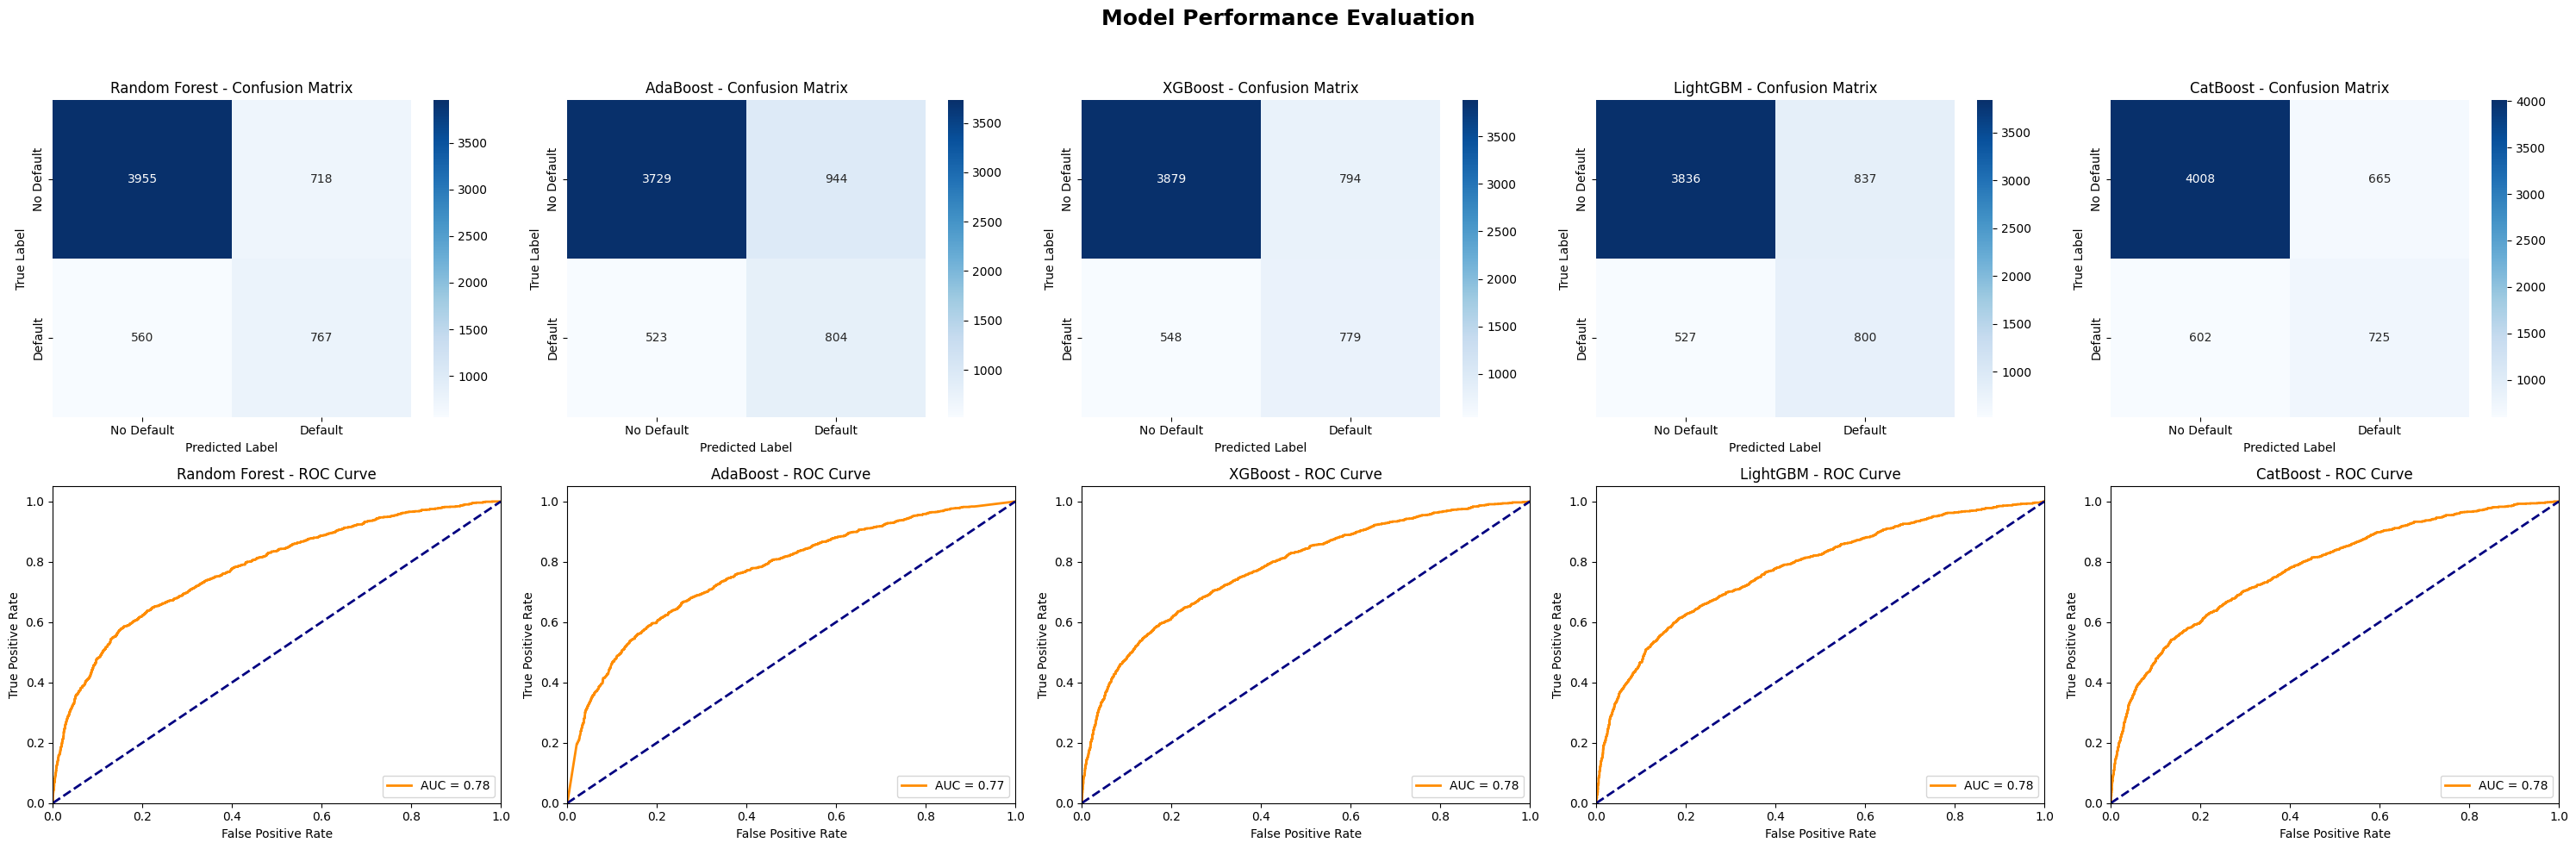


 Model Comparison Summary Table:
| Model         |   Accuracy |   Precision |   Recall |   F1 Score |   ROC AUC | Training Time   |
|:--------------|-----------:|------------:|---------:|-----------:|----------:|:----------------|
| Random Forest |     0.787  |      0.5165 |   0.578  |     0.5455 |    0.7778 | 2 min 45 sec    |
| AdaBoost      |     0.7555 |      0.46   |   0.6059 |     0.5229 |    0.7681 | 3 min 5 sec     |
| XGBoost       |     0.7763 |      0.4952 |   0.587  |     0.5372 |    0.7805 | 0 min 41 sec    |
| LightGBM      |     0.7727 |      0.4887 |   0.6029 |     0.5398 |    0.7757 | 0 min 33 sec    |
| CatBoost      |     0.7888 |      0.5216 |   0.5463 |     0.5337 |    0.7783 | 18 min 53 sec   |


In [149]:
# Set up plotting area
fig, axes = plt.subplots(2, len(best_models), figsize=(6 * len(best_models), 10))
fig.suptitle("Model Performance Evaluation", fontsize=18, fontweight='bold')

print("\nModel Evaluation Results:")
print("=" * 60)

# Collect metrics for table
metrics_summary = []

for idx, (model_name, model_info) in enumerate(best_models.items()):
    model = model_info["best_estimator"]
    
    predictions = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)[:, 1]

    # Compute metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, pred_proba)

    total_seconds = model_info["training_time_seconds"]
    minutes = int(total_seconds // 60)
    seconds = int(total_seconds % 60)
    training_time = f"{minutes} min {seconds} sec"

    # Append metrics to summary table
    metrics_summary.append({
        "Model": model_name,
        "Accuracy": round(accuracy, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1 Score": round(f1, 4),
        "ROC AUC": round(roc_auc, 4),
        "Training Time": training_time
    })

    print(f"\n{model_name} Results:")
    print("-" * 40)
    print(f"Training time: {training_time}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    cm = confusion_matrix(y_test, predictions)
    print("\nConfusion Matrix:")
    print(cm)

    print("\nClassification Report:")
    print(classification_report(y_test, predictions, target_names=["No Default", "Default"]))

    # Confusion matrix heatmap
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["No Default", "Default"],
        yticklabels=["No Default", "Default"],
        ax=axes[0, idx]
    )
    axes[0, idx].set_title(f"{model_name} - Confusion Matrix")
    axes[0, idx].set_xlabel("Predicted Label")
    axes[0, idx].set_ylabel("True Label")

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, pred_proba)
    axes[1, idx].plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
    axes[1, idx].plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    axes[1, idx].set_xlim([0.0, 1.0])
    axes[1, idx].set_ylim([0.0, 1.05])
    axes[1, idx].set_xlabel("False Positive Rate")
    axes[1, idx].set_ylabel("True Positive Rate")
    axes[1, idx].set_title(f"{model_name} - ROC Curve")
    axes[1, idx].legend(loc="lower right")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Create and display summary DataFrame
df_metrics = pd.DataFrame(metrics_summary)
print("\n Model Comparison Summary Table:")
print(df_metrics.to_markdown(index=False))

### Performance Analysis

#### Training Efficiency
- **Fastest Training**: LightGBM (33 sec)
- **Slowest Training**: CatBoost (18 min 53 sec)

#### Accuracy Leaders
1. CatBoost (78.9%)
2. Random Forest (78.7%) 
3. XGBoost (77.6%)

#### Precision-Recall Tradeoffs
| Model       | Precision | Recall | Best Use Case                          |
|-------------|-----------|--------|----------------------------------------|
| Random Forest | 51.7%   | 57.8%  | General purpose                        |
| AdaBoost    | 46.0%     | 60.6%  | Fraud detection (higher false positives)|
| XGBoost     | 49.5%     | 58.7%  | Balanced requirements                  |
| LightGBM    | 48.9%     | 60.3%  | Balanced requirements                  |
| CatBoost    | 52.2%     | 54.6%  | Regulatory reporting                   |

#### Key Insights
1. **Class Imbalance Challenge**: All models struggle with default class (precision <53%)
2. **Boosting Advantages**: 
   - XGBoost/LightGBM offer best speed/performance balance
   - CatBoost handles categoricals best but slower

## 8. Feature Importance<a name="feature-importance"></a>



Feature Importance Summary:

Random Forest Top 10 Features:
----------------------------------------
max_payment_delay             : 0.1370
pay_0                         : 0.1152
pay_2                         : 0.0629
payment_delay_trend           : 0.0482
pay_3                         : 0.0386
pay_amt1                      : 0.0327
utilization_ratio_1           : 0.0319
pay_4                         : 0.0303
bill_amt1                     : 0.0302
pay_amt2                      : 0.0299

AdaBoost Top 10 Features:
----------------------------------------
pay_0                         : 0.2580
max_payment_delay             : 0.1793
utilization_ratio_2           : 0.0447
pay_amt2                      : 0.0445
utilization_ratio_1           : 0.0395
bill_amt1                     : 0.0368
pay_amt1                      : 0.0351
pay_amt3                      : 0.0277
age                           : 0.0248
utilization_ratio_6           : 0.0216

XGBoost Top 10 Features:
------------------------

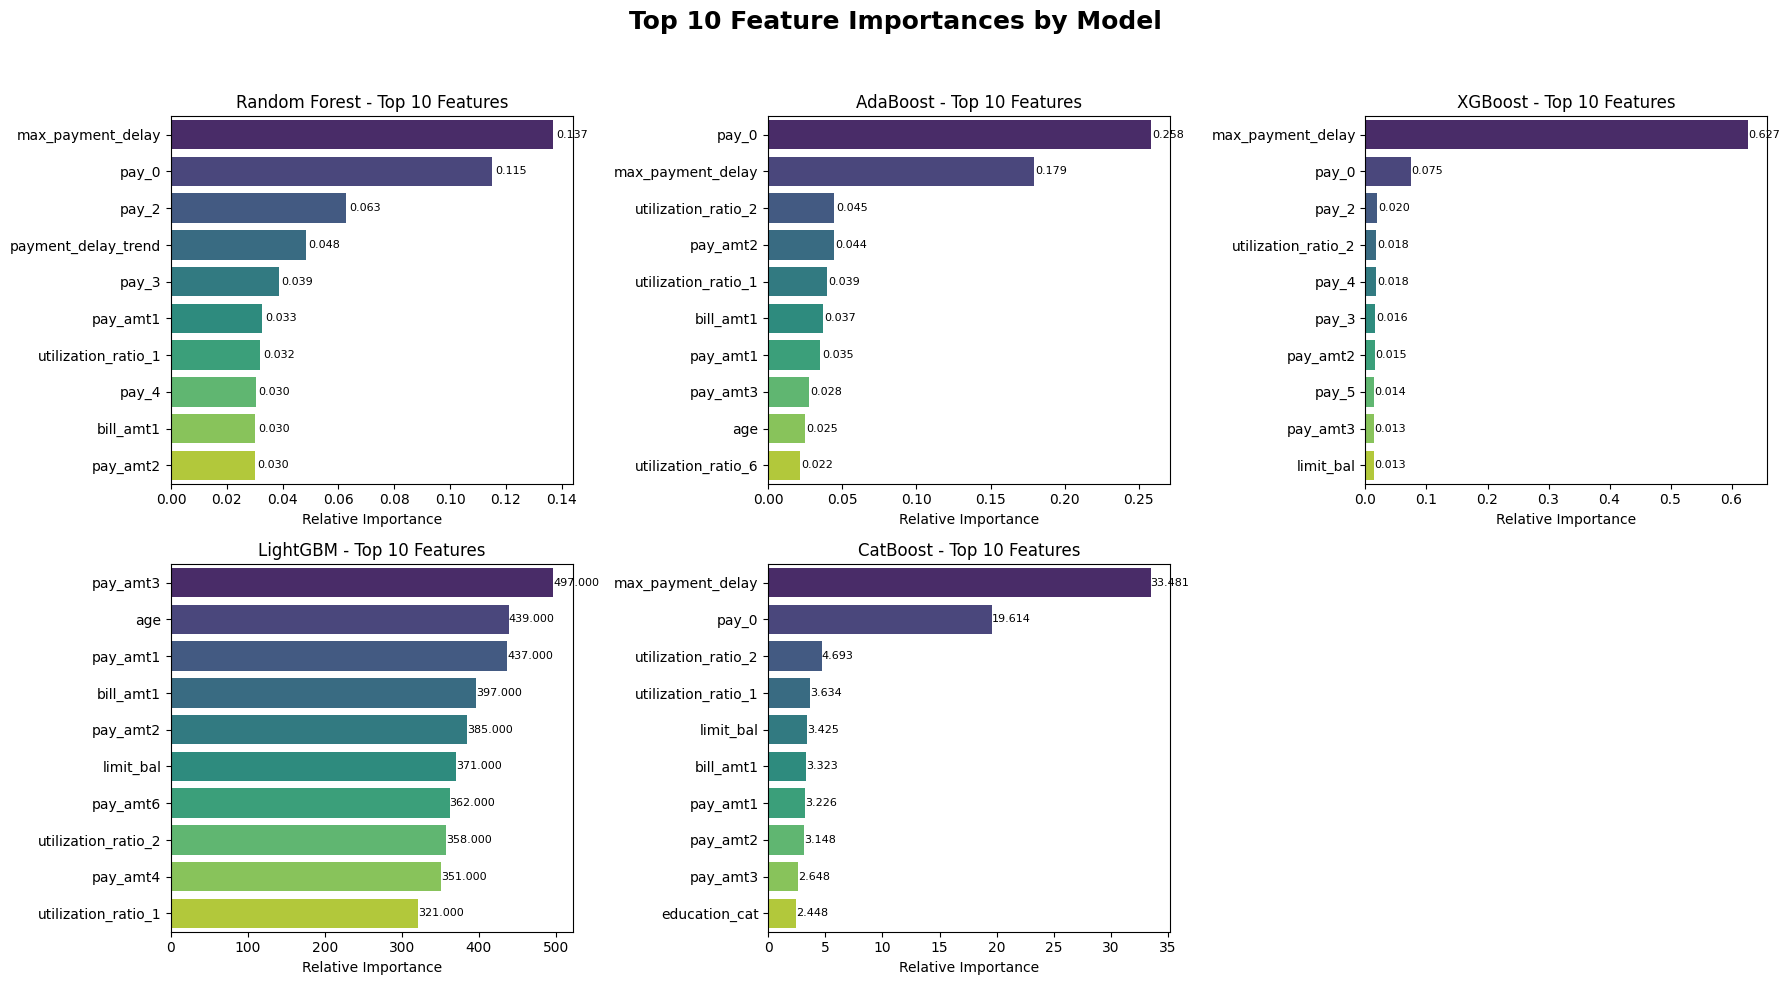

In [151]:
# Feature Importance Analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

fig.suptitle("Top 10 Feature Importances by Model", fontsize=18, fontweight='bold')

print("\nFeature Importance Summary:")
print("=" * 60)

for idx, (model_name, model_info) in enumerate(best_models.items()):
    if idx >= 6:
        break  

    model = model_info["best_estimator"]

    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        # Get feature names
        feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(len(importances))]
        top_features = [feature_names[i] for i in indices[:10]]
        top_importances = importances[indices[:10]]

        print(f"\n{model_name} Top 10 Features:")
        print("-" * 40)
        for f, imp in zip(top_features, top_importances):
            print(f"{f:<30}: {imp:.4f}")

        # Plot barplot
        sns.barplot(
            x=top_importances,
            y=top_features,
            palette="viridis",
            ax=axes[idx]
        )
        axes[idx].set_title(f"{model_name} - Top 10 Features")
        axes[idx].set_xlabel("Relative Importance")
        axes[idx].set_ylabel("")

        # Add value labels
        for i, v in enumerate(top_importances):
            axes[idx].text(v + 0.001, i, f"{v:.3f}", va='center', fontsize=8)
    else:
        print(f"\n{model_name} does not support feature importances.")
        fig.delaxes(axes[idx])  # Remove unused plot

# Hide any extra subplots in the grid
for j in range(len(best_models), 6):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Key Feature Importance Insights

#### Dominant Predictors
- **`pay_0`** (recent payment status) and **`max_payment_delay`** emerge as top features across most models  
- Payment behavior is the strongest indicator of default risk  

#### Model-Specific Patterns
| Model       | Top Features                          | Unique Focus                |
|-------------|---------------------------------------|-----------------------------|
| Random Forest | `pay_0`, trend features              | Uses payment patterns       |
| AdaBoost    | `pay_0`, `max_payment_delay`          | Recent delinquency          |
| XGBoost     | `pay_0`, `limit_bal`                  | Balanced payment history    |
| LightGBM    | Payment amounts (`pay_amt3`)           | Uniquely prioritizes amounts|
| CatBoost    | `pay_0`, credit utilization ratios    | Includes education          |


#### Insights
1. **Payment monitoring** should be central to risk assessment
2. **Credit utilization** metrics are secondary but important predictors
3. Demographic features (`age`, `education`) show minimal impact
4. **Model selection matters** - different algorithms surface different key features

## 9. Conclusion<a name="conclusion"></a>


This credit default prediction project successfully developed and evaluated multiple machine learning models to identify high-risk customers. 

**Key takeaways:**

1. **Model Performance**  
- CatBoost achieved highest accuracy (78.9%)  
- AdaBoost showed best recall (60.6%) for catching defaults  
- XGBoost offered optimal balance of speed and performance  

2. **Critical Risk Factors**  
- Payment delays (`pay_0`, `max_payment_delay`) were most predictive  
- Credit utilization ratios were secondary indicators  
- Demographic factors had minimal impact  

